In [1]:
from acevedo_clss_and_fcns import * 
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")
from torch_geometric.nn import GNNExplainer

    

model = torch.load("results/trained_pytorch_models/Model_GIN_classifier_to_explain_17-10-2022_23h_00min_best_ValAcc_0.9641644662391551_epoch_10.pt")
#loader_path = "./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt"
loader_path = "./results/dataloaders/loader_Concen_plus_Fluxes.pt"
loader = torch.load(loader_path).get_validation_loader()



/DeepenData/.miniconda/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = 'cuda:0'


Explain graph: 100%|██████████| 999/999 [01:27<00:00, 11.42it/s]


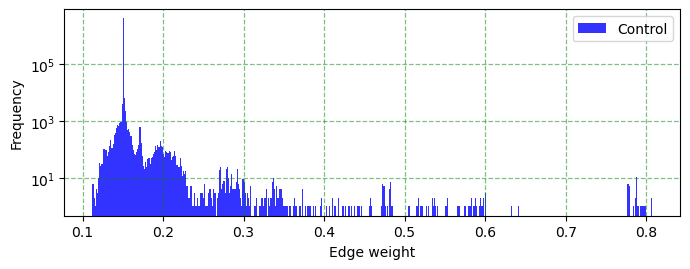

In [2]:


explainer  = GNNExplainer(model, epochs=999, num_hops = 2, lr=0.002).to(device, non_blocking=True)
model.to(device, non_blocking=True)
a_batch = next(iter(loader)).to(device, non_blocking=True)
model.eval()
gc.collect()
torch.cuda.empty_cache() 
node_feat_mask, edge_mask =  explainer.explain_graph(a_batch.x, a_batch.edge_index)
import matplotlib.pyplot as plt
import pandas as pd

pd.Series(edge_mask.cpu().numpy()).plot.hist(bins=500, logy = True, figsize=(7,2.8), grid=False, color = 'blue', alpha=.8)
plt.xlabel('Edge weight')
plt.tight_layout()
plt.grid(color = 'green', linestyle = '--', linewidth = 0.9, alpha=.5)
#plt.xlim([0, 1])
plt.legend(['Control'])
plt.show()


In [3]:
import networkx as nx

pyg_graph = a_batch[0]
nx_G      = nx.read_gpickle(
"results/graphs_from_PYG_and_NX/grafo_nx_Concen_plus_Fluxes.gpickle")
explainer_subgraphs_df =  pd.DataFrame(edge_mask.cpu().reshape(a_batch.y.__len__(), -1).numpy().transpose())
explainer_subgraphs_df[explainer_subgraphs_df < node_feat_mask.cpu().numpy()] = 0

explainer_subgraphs_df  = explainer_subgraphs_df.loc[:,explainer_subgraphs_df.sum() > 0]

In [7]:
explainer_subgraphs_df, explainer_subgraphs_df.sum()

(         0
 0      0.0
 1      0.0
 2      0.0
 3      0.0
 4      0.0
 ...    ...
 63361  0.0
 63362  0.0
 63363  0.0
 63364  0.0
 63365  0.0
 
 [63366 rows x 1 columns],
 0    195.730728
 dtype: float32)

In [8]:
edge_0_node_idxs =  pyg_graph.edge_index[0,:]
edge_1_node_idxs =  pyg_graph.edge_index[1,:]
edge_0_nodes     = [list(nx_G.nodes)[i] for i in  edge_0_node_idxs]
edge_1_nodes     = [list(nx_G.nodes)[i] for i in  edge_1_node_idxs]

In [9]:
edges_df = pd.DataFrame({'node1': edge_0_nodes, 'node2':edge_1_nodes})
edges_node_names_explainer_subgraphs = pd.concat([edges_df, explainer_subgraphs_df], axis=1)

In [10]:
edges_node_names_explainer_subgraphs

,node1,node2,0
0,AHEXASEly,h2o_l,0.0
1,AHEXASEly,m2mn_l,0.0
2,AHEXASEly,acgam_l,0.0
3,AHEXASEly,n2m2mn_l,0.0
4,c6crn_e,C6CRNe,0.0
...,...,...,...
63361,23dpg_c,DPGM,0.0
63362,r0915,cit_m,0.0
63363,r0915,succ_m,0.0
63364,r0915,succ_c,0.0


In [62]:
edges_node_names_explainer_subgraphs.to_csv("./results/data/edges_node_names_explainer_subgraphs.csv")
